# Tuned hyper parameters for multi-label classification

In [1]:
import pandas as pd
import numpy as np
import cv2    
import matplotlib.pyplot as plt
import seaborn as sns

from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import vgg16

from IPython.display import Image
import tensorflow as tf
import keras_tuner as kt

In [2]:
main_folder = 'input/celeba-dataset/'
images_folder = main_folder + 'img_align_celeba/'
weights_folder = 'weights/'
EXAMPLE_PIC = images_folder + '000506.jpg'

TRAINING_SAMPLES = 10000
VALIDATION_SAMPLES = 2000
TEST_SAMPLES = 2000
IMG_WIDTH = 224
IMG_HEIGHT = 224
BATCH_SIZE = 16
NUM_EPOCHS = 20

## ATTRIBUTE DF

In [3]:
# import the data set that include the attribute for each picture
df_attr = pd.read_csv(main_folder + 'list_attr_celeba.csv')
df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0

df_attr['Male'] = df_attr['Male'].astype(str)
df_attr['file_name']

0         000001.jpg
1         000002.jpg
2         000003.jpg
3         000004.jpg
4         000005.jpg
             ...    
202594    202595.jpg
202595    202596.jpg
202596    202597.jpg
202597    202598.jpg
202598    202599.jpg
Name: file_name, Length: 202599, dtype: object

## PARTITION DF (all features)

In [4]:
df_partition = pd.read_csv(main_folder + 'list_eval_partition.csv')
df_partition.head()
df_partition['val'].value_counts().sort_index()

# join the partition with the attributes
df_par_attr = df_partition.merge(df_attr)
df_par_attr

,file_name,val,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,0,1,1,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202594,202595.jpg,2,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
202595,202596.jpg,2,0,0,0,0,0,1,1,0,...,0,1,1,0,0,0,0,0,0,1
202596,202597.jpg,2,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
202597,202598.jpg,2,0,1,1,0,0,0,1,0,...,0,1,0,1,1,0,1,0,0,1


## Generate Train Dataset

In [5]:
df_train = df_par_attr[(df_par_attr['val'] == 0) & (df_par_attr['Male'] == '0')].sample(TRAINING_SAMPLES//2)
df_train = pd.concat([
    df_train,
    df_par_attr[(df_par_attr['val'] == 0) & (df_par_attr['Male'] == '1')].sample(TRAINING_SAMPLES//2)
])

df_train

,file_name,val,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
20847,020848.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
109638,109639.jpg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
77190,077191.jpg,0,0,1,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,1
45170,045171.jpg,0,0,0,1,1,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
162468,162469.jpg,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99490,099491.jpg,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
30348,030349.jpg,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
35594,035595.jpg,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
22912,022913.jpg,0,0,0,0,0,0,0,1,1,...,0,1,0,0,0,0,0,0,1,1


## Load images from folder

In [6]:
from keras.preprocessing.image import ImageDataGenerator

labels = ['Goatee', 'Heavy_Makeup', 'Pale_Skin', 'Rosy_Cheeks', 'Wearing_Earrings', 'Wearing_Lipstick', 'Wearing_Necklace']

# for col in df_par_attr.columns:
#     labels.append(col)
    
# labels.remove('file_name')
# labels.remove('val')
# labels.remove('Male')

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=df_train, 
    directory=images_folder, 
    x_col='file_name', 
    y_col=labels, 
    class_mode="raw", 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 10000 validated image filenames.


## Generate Validation Dataset

In [7]:
df_val = df_par_attr[(df_par_attr['val'] == 1) & (df_par_attr['Male'] == '0')].sample(VALIDATION_SAMPLES//2)
df_val = pd.concat([
    df_val,
    df_par_attr[(df_par_attr['val'] == 1) & (df_par_attr['Male'] == '1')].sample(VALIDATION_SAMPLES//2)
])

df_val

,file_name,val,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
177769,177770.jpg,1,0,1,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
181809,181810.jpg,1,0,0,1,1,0,0,0,0,...,0,1,0,1,0,0,0,0,0,1
168945,168946.jpg,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
172768,172769.jpg,1,0,1,1,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,1
170059,170060.jpg,1,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172796,172797.jpg,1,1,0,1,0,0,0,0,0,...,1,1,1,0,0,0,0,0,0,1
179043,179044.jpg,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
173189,173190.jpg,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
176295,176296.jpg,1,1,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [8]:
val_generator = datagen.flow_from_dataframe(
    dataframe=df_val, 
    directory=images_folder, 
    x_col='file_name', 
    y_col=labels, 
    class_mode="raw", 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=True
)

Found 2000 validated image filenames.


## Generate Test Dataset

In [35]:
df_test = df_par_attr[(df_par_attr['val'] == 2) & (df_par_attr['Male'] == '0')].sample(TEST_SAMPLES//2)
df_test = pd.concat([
    df_test,
    df_par_attr[(df_par_attr['val'] == 2) & (df_par_attr['Male'] == '1')].sample(TEST_SAMPLES//2)
])

df_test['file_name'].iloc[1]

'200511.jpg'

In [18]:
test_generator = datagen.flow_from_dataframe(
    dataframe=df_test, 
    directory=images_folder, 
    x_col='file_name', 
    y_col=labels, 
    class_mode="raw", 
    target_size=(IMG_HEIGHT, IMG_WIDTH), 
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2000 validated image filenames.


In [11]:
# df_train.plot(x="file_name", y=column, kind="bar", figsize=(9, 8))
# plt.show()
# col1 = df_train.value_counts('Male')
# col2 = df_train.value_counts('Young')

# distri = pd.DataFrame(distri)

In [12]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VAL = val_generator.n//val_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

## Model Creation (multi-label classification)

In [15]:
def generator_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(len(labels))])
        
#labels = ['Goatee', 'Heavy_Makeup', 'Pale_Skin', 'Rosy_Cheeks', 'Wearing_Earrings', 'Wearing_Lipstick', 'Wearing_Necklace']

# VGG 16 as base
base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(736, activation="tanh")(x)
x = Dropout(0.5)(x)
x = Dense(736, activation="tanh")(x)
Goatee = Dense(1, name='Goatee', activation = 'sigmoid')(x)
Heavy_Makeup = Dense(1, name='Heavy_Makeup', activation = 'sigmoid')(x)
Pale_Skin = Dense(1, name='Pale_Skin', activation = 'sigmoid')(x)
Rosy_Cheeks = Dense(1, name='Rosy_Cheeks', activation = 'sigmoid')(x)
Wearing_Earrings = Dense(1, name='Wearing_Earrings', activation = 'sigmoid')(x)
Wearing_Lipstick = Dense(1, name='Wearing_Lipstick', activation = 'sigmoid')(x)
Wearing_Necklace = Dense(1, name='Wearing_Necklace', activation = 'sigmoid')(x)

model = Model(inputs=base_model.input, outputs=[Goatee, Heavy_Makeup, Pale_Skin, Rosy_Cheeks, Wearing_Earrings, Wearing_Lipstick, Wearing_Necklace])
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss=["binary_crossentropy", "binary_crossentropy", "binary_crossentropy", "binary_crossentropy", "binary_crossentropy", "binary_crossentropy", "binary_crossentropy"],
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
        
model.fit(
    generator_wrapper(train_generator),
    steps_per_epoch=TRAINING_SAMPLES//BATCH_SIZE,
    validation_data=generator_wrapper(val_generator),
    validation_steps=STEP_SIZE_VAL,
    callbacks=[es],
    epochs=NUM_EPOCHS,
    verbose=1
)

model.save('weights/celeba_all')

Epoch 1/20
625/625 [==============================] - 69s 107ms/step - loss: 2.1694 - Goatee_loss: 0.2678 - Heavy_Makeup_loss: 0.3992 - Pale_Skin_loss: 0.1760 - Rosy_Cheeks_loss: 0.1983 - Wearing_Earrings_loss: 0.4142 - Wearing_Lipstick_loss: 0.3708 - Wearing_Necklace_loss: 0.3432 - Goatee_accuracy: 0.9195 - Heavy_Makeup_accuracy: 0.8173 - Pale_Skin_accuracy: 0.9581 - Rosy_Cheeks_accuracy: 0.9404 - Wearing_Earrings_accuracy: 0.8304 - Wearing_Lipstick_accuracy: 0.8348 - Wearing_Necklace_accuracy: 0.8837 - val_loss: 1.9881 - val_Goatee_loss: 0.3651 - val_Heavy_Makeup_loss: 0.3066 - val_Pale_Skin_loss: 0.1888 - val_Rosy_Cheeks_loss: 0.1745 - val_Wearing_Earrings_loss: 0.3566 - val_Wearing_Lipstick_loss: 0.2899 - val_Wearing_Necklace_loss: 0.3066 - val_Goatee_accuracy: 0.9055 - val_Heavy_Makeup_accuracy: 0.8705 - val_Pale_Skin_accuracy: 0.9620 - val_Rosy_Cheeks_accuracy: 0.9345 - val_Wearing_Earrings_accuracy: 0.8500 - val_Wearing_Lipstick_accuracy: 0.8730 - val_Wearing_Necklace_accuracy: 

## Prediction on test set

In [19]:
test_generator.reset()
score = model.evaluate(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

125/125 [==============================] - 14s 109ms/step - loss: 4.6782 - Goatee_loss: 0.9913 - Heavy_Makeup_loss: 0.5430 - Pale_Skin_loss: 0.7057 - Rosy_Cheeks_loss: 0.7573 - Wearing_Earrings_loss: 0.4151 - Wearing_Lipstick_loss: 0.8346 - Wearing_Necklace_loss: 0.4311 - Goatee_accuracy: 0.8251 - Heavy_Makeup_accuracy: 0.7388 - Pale_Skin_accuracy: 0.8259 - Rosy_Cheeks_accuracy: 0.8261 - Wearing_Earrings_accuracy: 0.8173 - Wearing_Lipstick_accuracy: 0.7029 - Wearing_Necklace_accuracy: 0.8261


In [36]:
test_generator.reset()
pred = model.predict(
    test_generator,
    steps=STEP_SIZE_TEST,
    verbose=1
)

125/125 [==============================] - 9s 74ms/step


In [44]:
pred[0]

array([[0.0239274 ],
       [0.01817335],
       [0.00215422],
       ...,
       [0.21303082],
       [0.3463758 ],
       [0.06179603]], dtype=float32)

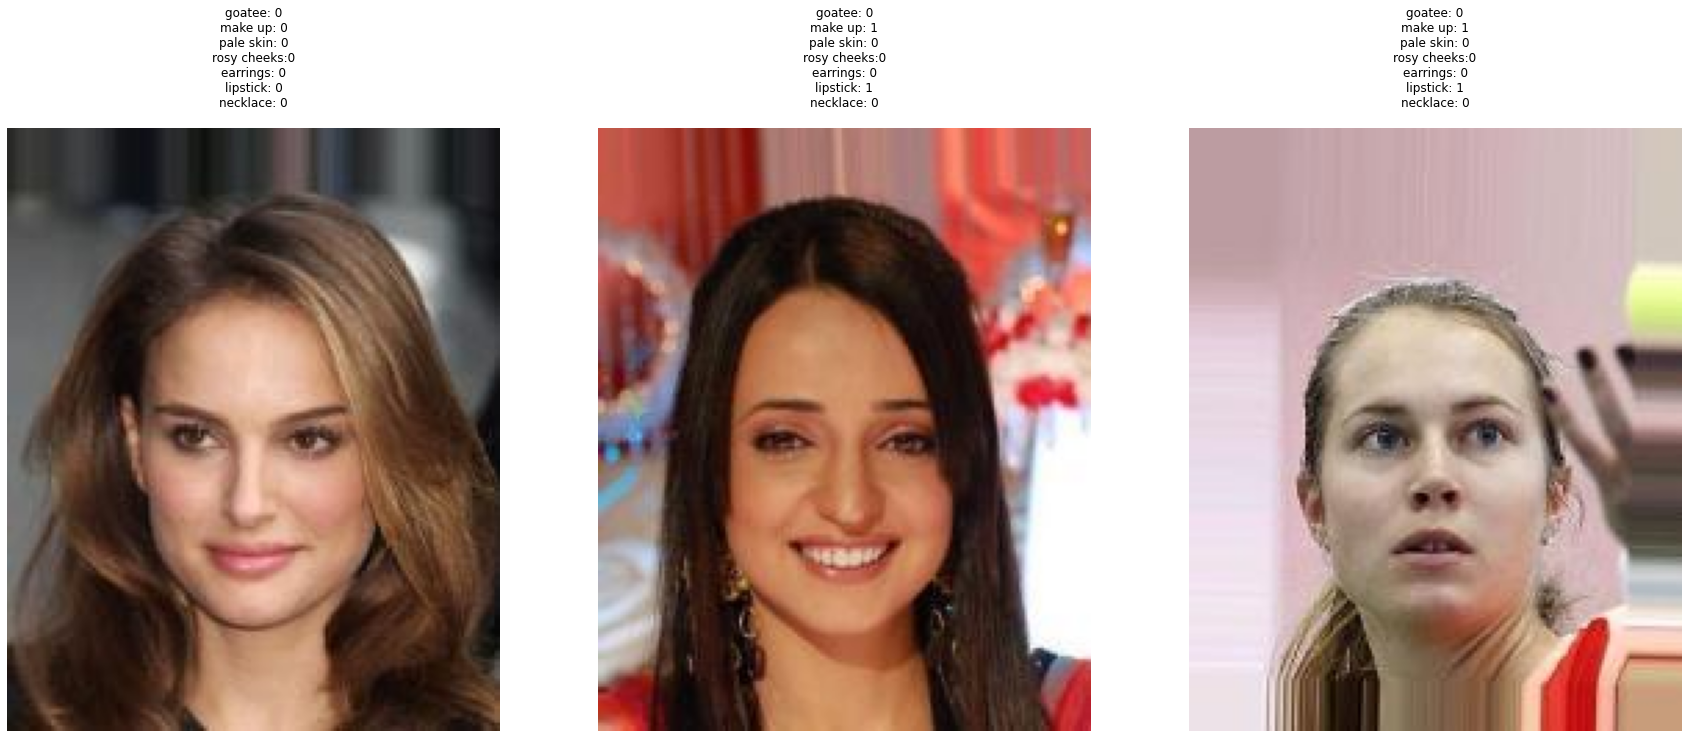

In [45]:
# alvin_img = load_img(custom_folder + 'alvin.jpg')

fig = plt.figure(figsize=(30, 20))

for i in range(3):
    fig.add_subplot(1, 3, i+1)
    plt.imshow(load_img(images_folder + df_test['file_name'].iloc[i]))
    plt.axis('off')
    if pred[0][i] > 0.5:
        has_goatee = 1
    else:
        has_goatee = 0
    if pred[1][i] > 0.5:
        has_heavy_makeup = 1
    else:
        has_heavy_makeup = 0
    if pred[2][i] > 0.5:
        has_pale_skin = 1
    else:
        has_pale_skin = 0
    if pred[3][i] > 0.5:
        has_rosy_cheeks = 1
    else:
        has_rosy_cheeks = 0
    if pred[4][i] > 0.5:
        has_earrings = 1
    else:
        has_earrings = 0
    if pred[5][i] > 0.5:
        has_lipstick = 1
    else:
        has_lipstick = 0
    if pred[6][i] > 0.5:
        has_necklace = 1
    else:
        has_necklace = 0        
    
        
    plt.title("goatee: {}\nmake up: {}\npale skin: {}\nrosy cheeks:{}\nearrings: {}\nlipstick: {}\nnecklace: {}\n".format(
        has_goatee, has_heavy_makeup, has_pale_skin, has_rosy_cheeks, has_earrings, has_lipstick, has_necklace
    ))  
    
    
# ['Goatee', 'Heavy_Makeup', 'Pale_Skin', 'Rosy_Cheeks', 'Wearing_Earrings', 'Wearing_Lipstick', 'Wearing_Necklace']